# Mount The Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Dataset Balancing & Train–Validation Split

In [4]:
import os, random, shutil, math, uuid
from pathlib import Path
from collections import Counter
import numpy as np
import tensorflow as tf

dataset_dir = "/content/drive/MyDrive/New_Dataset1"   # root with class subfolders
balanced_root = "/content/balanced_dataset1"
strategy = "undersample"            # "oversample" or "undersample"
img_size = 224
batch_size = 32
train_frac = 0.80
initial_epochs = 10
fine_tune_epochs = 5
random_seed = 42
# ------------------------------------------------

random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# --- 0) sanity check
dataset_path = Path(dataset_dir)
classes = [p.name for p in dataset_path.iterdir() if p.is_dir()]
if not classes:
    raise SystemExit(f"No class directories found in {dataset_dir}.")
print("Detected classes:", classes)

# --- 1) count current images
class_files = {}
counts = {}
for c in classes:
    files = [p for p in (dataset_path / c).glob('*') if p.is_file()]
    class_files[c] = files
    counts[c] = len(files)
print("Original counts:", counts)

# --- 2) choose target count
if strategy == "oversample":
    target_count = max(counts.values())
elif strategy == "undersample":
    target_count = min(counts.values())
else:
    raise ValueError("strategy must be 'oversample' or 'undersample'")
print(f"Balancing strategy: {strategy}, target_count per class: {target_count}")

# --- 3) create balanced pool directory (copies only) ---
pool_dir = Path(balanced_root) / "pool"
if pool_dir.exists():
    shutil.rmtree(pool_dir)
pool_dir.mkdir(parents=True, exist_ok=True)

for c in classes:
    (pool_dir / c).mkdir(parents=True, exist_ok=True)

    files = class_files[c]
    n = len(files)

    # If undersample: randomly pick target_count files
    if strategy == "undersample" and n > target_count:
        chosen = random.sample(files, target_count)
        for f in chosen:
            shutil.copy2(f, pool_dir / c / f.name)
        print(f"{c}: undersampled from {n} -> {target_count}")

    # If oversample: copy all original, then duplicate random picks until target_count
    elif strategy == "oversample":
        # copy originals
        for f in files:
            shutil.copy2(f, pool_dir / c / f.name)
        # duplicate random picks (with new filenames) until target_count
        i = 0
        while (pool_dir / c).exists() and len(list((pool_dir / c).glob('*'))) < target_count:
            if n == 0:
                raise SystemExit(f"Class {c} has 0 images, cannot oversample.")
            src = random.choice(files)
            new_name = f"{src.stem}_dup_{uuid.uuid4().hex[:8]}.jpg"
            shutil.copy2(src, pool_dir / c / new_name)
            i += 1
        final = len(list((pool_dir / c).glob('*')))
        print(f"{c}: oversampled from {n} -> {final}")

    else:
        # strategy undersample but n <= target_count (copy all)
        for f in files:
            shutil.copy2(f, pool_dir / c / f.name)
        print(f"{c}: copied as-is, count={n}")

# --- 4) create train/val split from pool ---
train_dir = Path(balanced_root) / "train"
val_dir = Path(balanced_root) / "val"
if train_dir.exists():
    shutil.rmtree(train_dir)
if val_dir.exists():
    shutil.rmtree(val_dir)
for d in [train_dir, val_dir]:
    d.mkdir(parents=True, exist_ok=True)

for c in classes:
    (train_dir / c).mkdir(parents=True, exist_ok=True)
    (val_dir / c).mkdir(parents=True, exist_ok=True)

    all_files = list((pool_dir / c).glob('*'))
    random.shuffle(all_files)
    n_train = int(len(all_files) * train_frac)
    train_files = all_files[:n_train]
    val_files = all_files[n_train:]
    for f in train_files:
        shutil.copy2(f, train_dir / c / f.name)
    for f in val_files:
        shutil.copy2(f, val_dir / c / f.name)
    print(f"{c}: train={len(train_files)}, val={len(val_files)}")

print("Balanced dataset ready at:", balanced_root)
print("Train/Val counts:", {c: len(list((train_dir / c).glob('*'))) for c in classes},
      {c: len(list((val_dir / c).glob('*'))) for c in classes})

Detected classes: ['wrinkles', 'dark_spots', 'clear_skin', 'puffy_eyes']
Original counts: {'wrinkles': 499, 'dark_spots': 497, 'clear_skin': 497, 'puffy_eyes': 409}
Balancing strategy: undersample, target_count per class: 409
wrinkles: undersampled from 499 -> 409
dark_spots: undersampled from 497 -> 409
clear_skin: undersampled from 497 -> 409
puffy_eyes: copied as-is, count=409
wrinkles: train=327, val=82
dark_spots: train=327, val=82
clear_skin: train=327, val=82
puffy_eyes: train=327, val=82
Balanced dataset ready at: /content/balanced_dataset1
Train/Val counts: {'wrinkles': 327, 'dark_spots': 327, 'clear_skin': 327, 'puffy_eyes': 327} {'wrinkles': 82, 'dark_spots': 82, 'clear_skin': 82, 'puffy_eyes': 82}


# Encoded class labels

In [5]:
classes = sorted(classes)   # this keep fixed order
class_to_index = {c: i for i, c in enumerate(classes)}
index_to_class = {i: c for c, i in class_to_index.items()}

print("Class to index:", class_to_index)


Class to index: {'clear_skin': 0, 'dark_spots': 1, 'puffy_eyes': 2, 'wrinkles': 3}


# Balanced Class Distribution Visualization

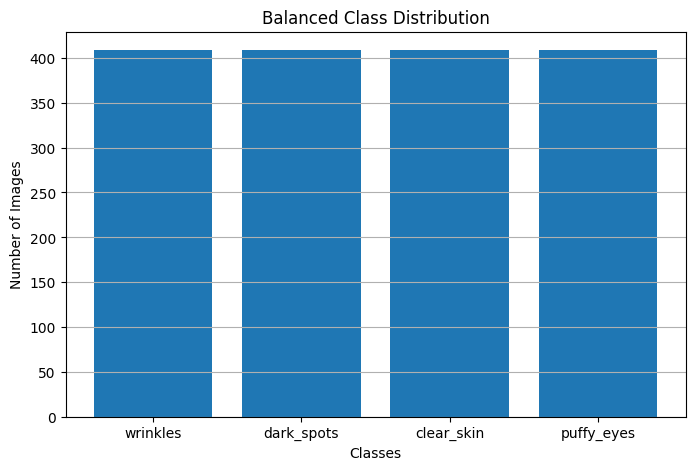

In [ ]:
import matplotlib.pyplot as plt
balanced_counts = {c: len(list((pool_dir / c).glob('*'))) for c in classes}

labels = list(balanced_counts.keys())
values = list(balanced_counts.values())

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.title("Balanced Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()


# EfficientNetB0 Model Training on Balanced Dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    str(train_dir),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    str(val_dir),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
print("Classes:", train_gen.class_indices)
print("Train samples:", train_gen.samples, "Val samples:", val_gen.samples)

# Build model with a richer head
base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
base.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.activations.relu(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base.input, outputs=outputs)

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
ckpt_path = "best_balanced1_noaug.keras"
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]

# Initial training (head)
history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epochs,
    steps_per_epoch=math.ceil(train_gen.samples / batch_size),
    validation_steps=math.ceil(val_gen.samples / batch_size),
    callbacks=callbacks
)

Found 1308 images belonging to 4 classes.
Found 328 images belonging to 4 classes.
Classes: {'clear_skin': 0, 'dark_spots': 1, 'puffy_eyes': 2, 'wrinkles': 3}
Train samples: 1308 Val samples: 328
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.5210 - loss: 1.1675
Epoch 1: val_accuracy improved from -inf to 0.80793, saving model to best_balanced1_noaug.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 68s 967ms/step - accuracy: 0.5238 - loss: 1.1612 - val_accuracy: 0.8079 - val_loss: 0.6633 - learning_rate: 1.0000e-04
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8286 - loss: 0.4907
Epoch 2: val_accuracy improved from 0.80793 to 0.84756, saving model to best_balanced1_noaug.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.8287 - loss: 0.4903 - val_accuracy: 0.8476 - val_loss: 0.5070 - learning_rate: 1.0000e-04
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8823 - loss: 0.3651
Epoch 3: val_accuracy improved from 0.84756 to 0.87500, saving model to best_balanced1_noaug.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.8822 - loss: 0.3654 - val_accuracy: 0.8750 - val_loss: 0.4258 - learning_rate: 1.0000e-04
Epoch 4/10
41/41 ━━━━━━━━

# Final Training and Validation Accuracy Results

In [ ]:
# Print final accuracies
final_train_accuracy = history_head.history['accuracy'][-1]
final_val_accuracy = history_head.history['val_accuracy'][-1]

print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Accuracy: 0.9480122327804565
Final Validation Accuracy: 0.9024389982223511


# Saving Trained EfficientNetB0 Model

In [ ]:
model.save("/content/best_balanced1_noaug.keras")
print("Saved model: best_balanced1_noaug.keras")

Saved model: best_balanced1_noaug.keras


# Zipping Balanced Dataset for Download

In [ ]:
import shutil

shutil.make_archive("balanced_dataset1", 'zip', "/content/balanced_dataset1")
print("✔ Dataset zipped as balanced_dataset1.zip")

✔ Dataset zipped as balanced_dataset1.zip


# Training & Validation Accuracy and Loss Curves

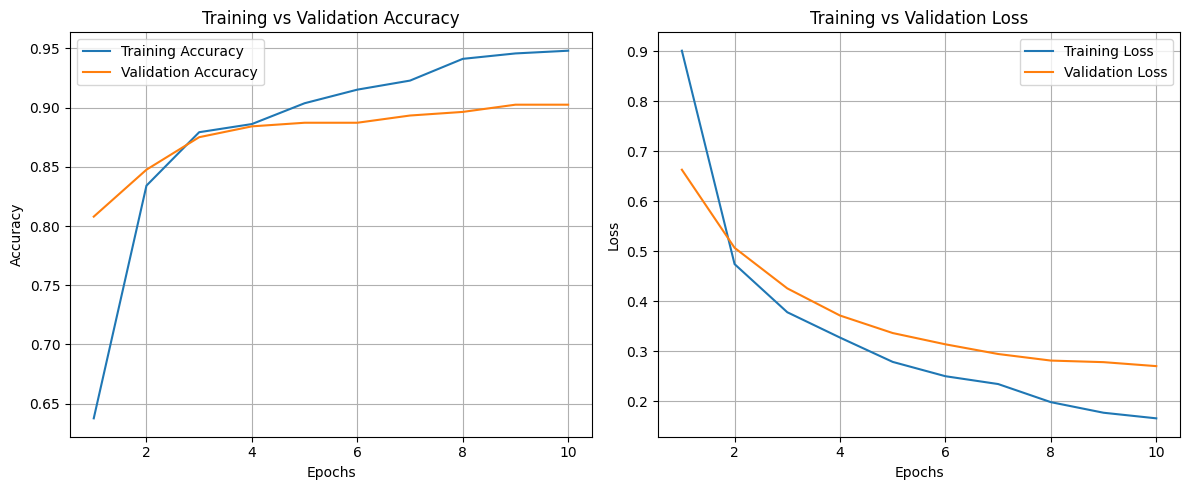

In [ ]:
import matplotlib.pyplot as plt

acc = history_head.history['accuracy']
val_acc = history_head.history['val_accuracy']
loss = history_head.history['loss']
val_loss = history_head.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# ---- Accuracy subplot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ---- Loss subplot ----
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Skin Analysis with Face Detection & Prediction

In [8]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load Haar cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# the .keras model
model = load_model("/content/drive/MyDrive/best_balanced1_noaug.keras")

CLASS_NAMES = ['wrinkles', 'puffy_eyes', 'dark_spot','clear_skin']  # <-- your classes

def analyze_skin(img_path):
    img = cv2.imread(img_path)
    orig = img.copy()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)


    # CASE 1: FACE DETECTED

    if len(faces) > 0:
        print("✓ Face detected")
        for (x, y, w, h) in faces:
            roi = img[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, (224, 224))
            roi_normalized = roi_resized / 255.0
            roi_normalized = np.expand_dims(roi_normalized, axis=0)

            pred = model.predict(roi_normalized)[0]
            idx = np.argmax(pred)
            label = f"{CLASS_NAMES[idx]} ({pred[idx]*100:.1f}%)"

            # Draw box + label
            cv2.rectangle(orig, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(orig, label, (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
        return orig


    # CASE 2: NO FACE → USE FULL IMAGE

    print("⚠ No face detected — analyzing full image")
    resized = cv2.resize(img, (224, 224))
    normalized = resized / 255.0
    normalized = np.expand_dims(normalized, axis=0)

    pred = model.predict(normalized)[0]
    idx = np.argmax(pred)
    label = f"{CLASS_NAMES[idx]} ({pred[idx]*100:.1f}%)"

    # Draw label on full image
    cv2.putText(orig, label, (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 3)

    return orig


# Displaying Skin Prediction Result

⚠ No face detected — analyzing full image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


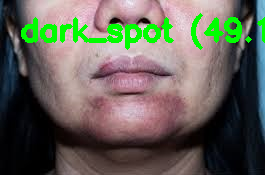

In [11]:

# DISPLAY RESULT
from google.colab.patches import cv2_imshow

# IMAGE PATH
image_path = "/content/balanced_dataset1/train/dark_spots/dark_spots_0006.jpg"   # change this to your image path

# Analyze image
output_img = analyze_skin(image_path)

# Show output
cv2_imshow(output_img)
